In [1]:
#ライブラリインストール
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
#自作ライブラリインストール
from module import read_netcdf
from module import latlon

In [3]:
output_xr = read_netcdf.read_netcdfs(start_date=datetime.datetime.strptime('2020-04-01 00:00', '%Y-%m-%d %H:%M'),
                                    end_date= datetime.datetime.strptime('2020-04-02 00:00', '%Y-%m-%d %H:%M'),
                                    dim = 'time',
                                    netcdf_folder_path= "netcdf/",
                                    transform_func = lambda ds: ds.isel(time = slice(8,11)) #24-27時間目を読み出す                                                            
)

['netcdf\\Z__C_RJTD_20200401000000_MSM_GPV_Rjp_Lsurf_FH16-33_grib2.nc', 'netcdf\\Z__C_RJTD_20200401030000_MSM_GPV_Rjp_Lsurf_FH16-33_grib2.nc', 'netcdf\\Z__C_RJTD_20200401060000_MSM_GPV_Rjp_Lsurf_FH16-33_grib2.nc', 'netcdf\\Z__C_RJTD_20200401090000_MSM_GPV_Rjp_Lsurf_FH16-33_grib2.nc', 'netcdf\\Z__C_RJTD_20200401120000_MSM_GPV_Rjp_Lsurf_FH16-33_grib2.nc', 'netcdf\\Z__C_RJTD_20200401150000_MSM_GPV_Rjp_Lsurf_FH16-33_grib2.nc', 'netcdf\\Z__C_RJTD_20200401180000_MSM_GPV_Rjp_Lsurf_FH16-33_grib2.nc', 'netcdf\\Z__C_RJTD_20200401210000_MSM_GPV_Rjp_Lsurf_FH16-33_grib2.nc']
読み出し完了：dataset読み込み時間：1.497s


In [4]:
#確認
output_xr

<xarray.Dataset>
Dimensions:              (latitude: 505, longitude: 481, time: 24)
Coordinates:
  * latitude             (latitude) float64 22.4 22.45 22.5 ... 47.5 47.55 47.6
  * longitude            (longitude) float64 120.0 120.1 120.1 ... 149.9 150.0
  * time                 (time) datetime64[ns] 2020-04-02 ... 2020-04-02T23:0...
Data variables:
    PRMSL_meansealevel   (time, latitude, longitude) float32 1.019e+05 ... 9....
    PRES_surface         (time, latitude, longitude) float32 1.019e+05 ... 9....
    UGRD_10maboveground  (time, latitude, longitude) float32 -0.6058 ... 6.533
    VGRD_10maboveground  (time, latitude, longitude) float32 -1.63 ... -11.88
    TMP_1D5maboveground  (time, latitude, longitude) float32 295.9 ... 273.0
    RH_1D5maboveground   (time, latitude, longitude) float32 77.48 ... 78.71
    LCDC_surface         (time, latitude, longitude) float32 20.7 20.75 ... 0.0
    MCDC_surface         (time, latitude, longitude) float32 45.46 41.41 ... 0.0
    HCDC_surface         (time, latitude, longitude) float32 9.521 ... 49.8
    TCDC_surface         (time, latitude, longitude) float32 45.46 ... 49.8
    APCP_surface         (time, latitude, longitude) float32 0.0 0.0 ... 0.0 0.0
    DSWRF_surface        (time, latitude, longitude) float32 161.7 ... 417.1
Attributes:
    Conventions:          COARDS
    History:              created by wgrib2
    GRIB2_grid_template:  0

## 読み込めたので地図を書いてみよう

In [ ]:
## 変数と単位をdictで保存
variable_list = [k for k , v in output_xr.items()]
variable_dict = {}
for var in variable_list:
    variable_dict[var] = output_xr[var].attrs

In [5]:
#予測する都市の緯度経度 前橋 E139度03.6分, N36.24.3分

lat = 36 + 24.3/60
lon = 139 + 3.6/60

print(lat, lon)
#msmの一番近い格子点を見つける
grid_point = latlon.get_closest_latlon(lat, lon)

lat_grid = grid_point[1]
lon_gird = grid_point[0]
area = 100 #地点の上下左右何地点を入れるか ⇒出力データは ((area+1)*2)* ((area+1)*2)の正方形

lat_south = round(lon_gird - 0.05*area,3) #以上0.05刻み
lat_north =  round(lon_gird  + 0.05*(area+1),3)#未満
lon_west =   round(lat_grid  - 0.0625*area,3)#以上0.0625刻み
lon_east =   round(lat_grid + 0.0625*(area+1),3)#以下

print('-'*15 + '緯度経度スライス完了' +'-'*15)
print(f'対象範囲 北緯:{lat_south}~{lat_north} , 東経:{lon_west}~{lon_east}')

36.405 139.06
最も近い格子点の座標: [ 36.4    139.0625]
---------------緯度経度スライス完了---------------
対象範囲 北緯:31.4~41.45 , 東経:132.812~145.374


In [6]:
def plot_var_whole(variable_dict, var, time):
    fig = plt.figure()
    ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=0))
    ax.coastlines()
    contourf = ax.contourf(
        output_xr["longitude"], 
        output_xr["latitude"], 
        output_xr[var][time], 
        transform=ccrs.PlateCarree(),
        )
    #前橋市の位置の表示
    ax.plot(lon, lat, marker='*', markersize=7 , color = 'red')
    ax.text(lon-0.6, lat+0.5, s = '前橋', fontsize=10 , color = 'white' , weight = 'bold')

    #タイトル表示
    ax.set_title(label= variable_dict[var]['long_name'])
    #時間の表示(相対位置で表示) UTC -JST変換
    plot_time =  output_xr[var][time].time.values +np.timedelta64(9,'h')
    ax.text(x = 0.5 , y = 0.05, s = pd.to_datetime(str(plot_time)).strftime('%Y年%m月%d日%H:00時'), transform=ax.transAxes)

    xticks = np.arange(73)*5
    yticks = -90 + np.arange(37)*5
    ax.set_xticks(xticks,crs=ccrs.PlateCarree())
    ax.set_yticks(yticks,crs=ccrs.PlateCarree())
    cb =fig.colorbar(contourf)
    cb.set_label(label= variable_dict[var]['units'], size = 12)
    ax.set_extent([lon_west,lon_east,lat_south,lat_north],crs=ccrs.PlateCarree())
    plt.show()

PRMSL_meansealevel


d:\anaconda\envs\netcdf_xarray\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  return super().draw(renderer=renderer, **kwargs)
d:\anaconda\envs\netcdf_xarray\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Glyph 27211 (\N{CJK UNIFIED IDEOGRAPH-6A4B}) missing from current font.
  return super().draw(renderer=renderer, **kwargs)
d:\anaconda\envs\netcdf_xarray\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  return super().draw(renderer=renderer, **kwargs)
d:\anaconda\envs\netcdf_xarray\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  return super().draw(renderer=renderer, **kwargs)
d:\anaconda\envs\netcdf_xarray\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from 

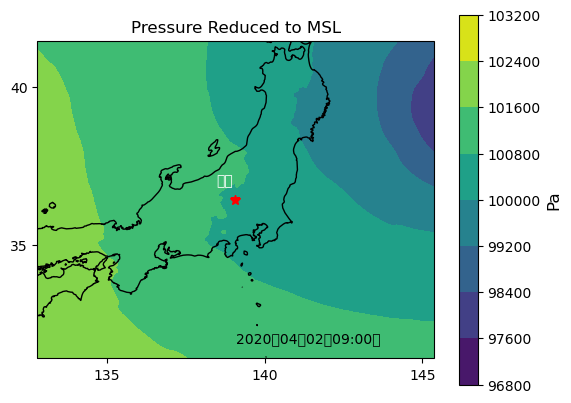

PRES_surface


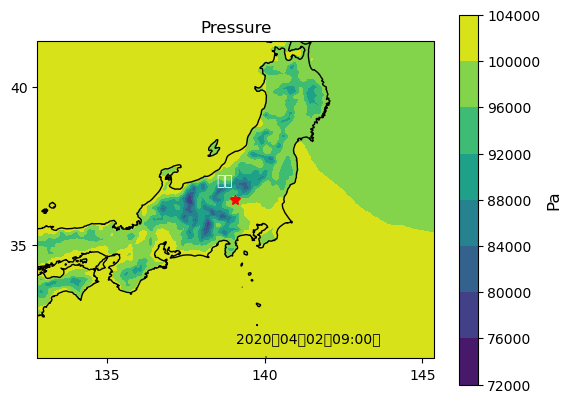

UGRD_10maboveground


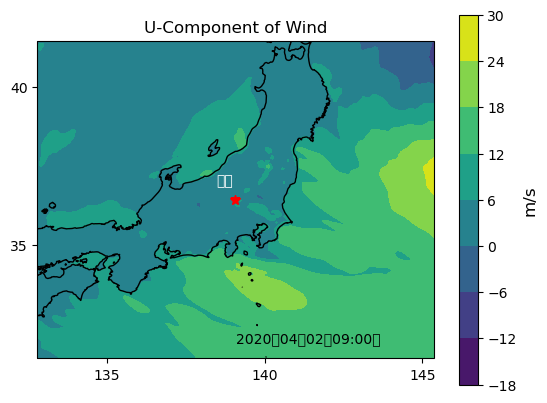

VGRD_10maboveground


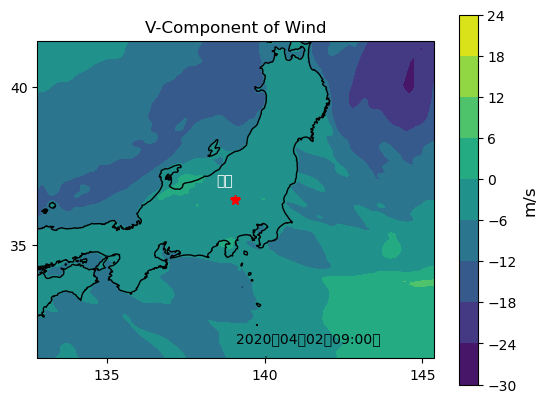

TMP_1D5maboveground


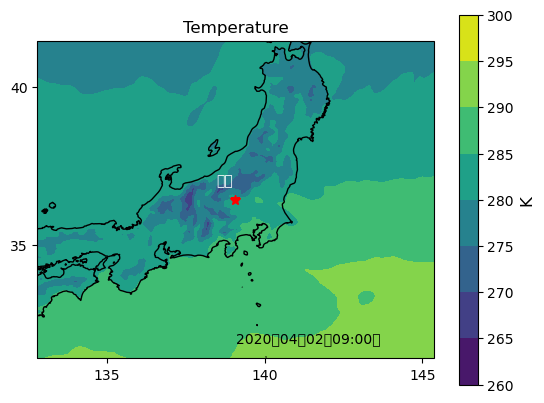

RH_1D5maboveground


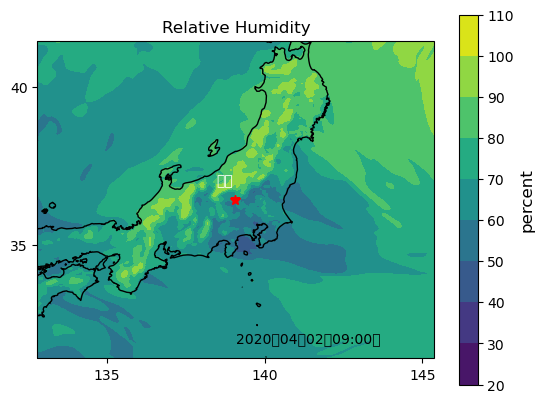

LCDC_surface


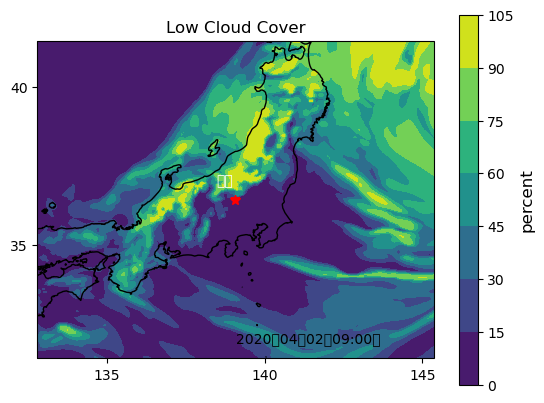

MCDC_surface


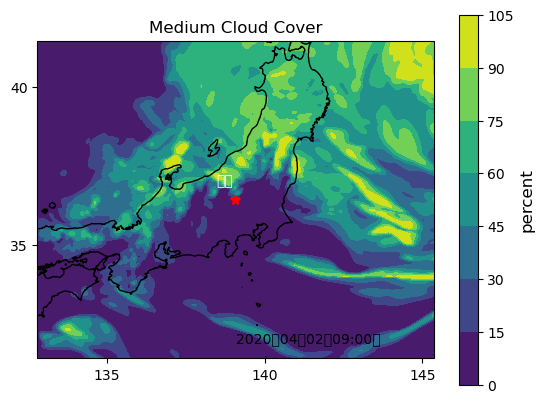

HCDC_surface


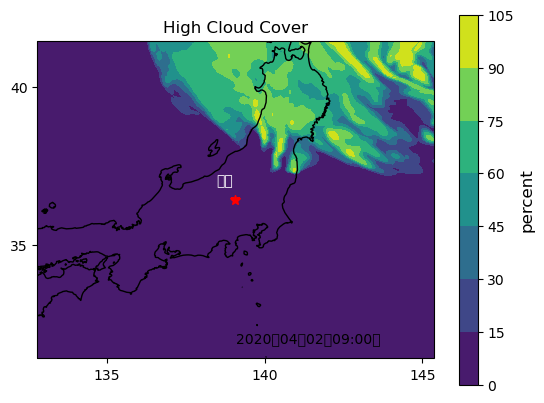

TCDC_surface


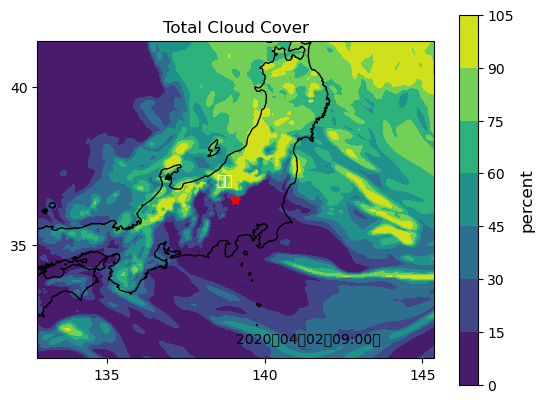

APCP_surface


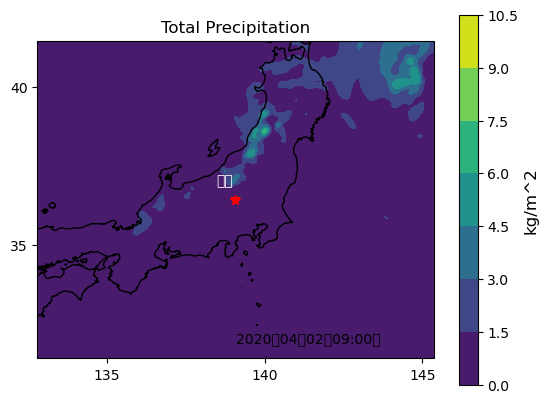

DSWRF_surface


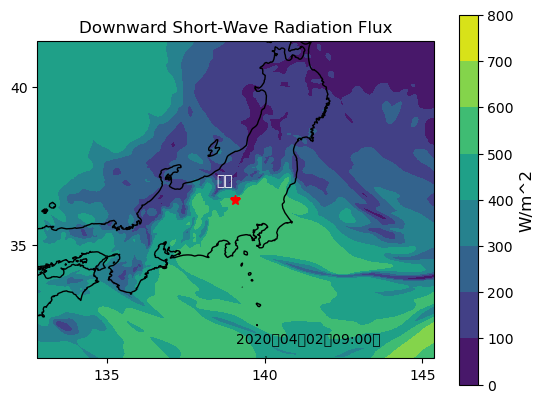

In [17]:
for var in variable_dict:
    print(var)
    for time in range(1):
        plot_var_whole(variable_dict , var , time)